In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from scipy.interpolate import interp1d

from solve_SIR import solveSIR


In [2]:
data = pd.read_csv("/Users/omarafifi/MyFolders/Differential-Game-Theory-for-SIR-Models/Data/formatted_data.csv")
S, I, R = data['S'].to_numpy(), data['I'].to_numpy(),  data['R'].to_numpy()
S_0, I_0, R_0  = float(S[0]), float(I[0]), float(R[0])


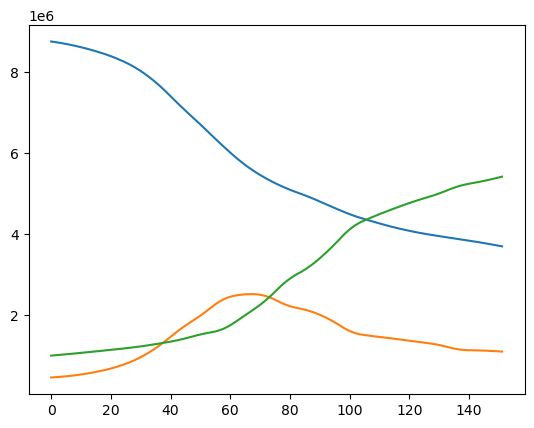

In [3]:
plt.plot(np.array([S,I,R]).T)

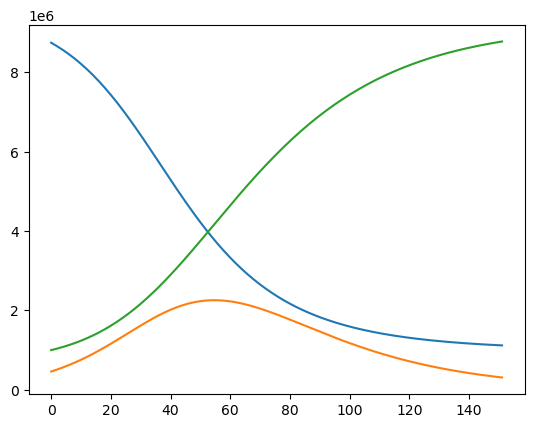

In [4]:
solver = solveSIR(S_true = S, I_true = I,
                  R_true = R, N = 10200000, 
                  p_0 = (.108, .04, S_0, I_0, R_0))

V = solver.forwardSolve()
solver.S_hat =  interp1d(np.arange(len(V)), V[:, 0], 
                kind = 'quadratic', fill_value="extrapolate", axis=-1)
solver.I_hat =  interp1d(np.arange(len(V)), V[:, 1], 
        kind = 'quadratic', fill_value="extrapolate", axis=-1)
solver.R_hat =  interp1d(np.arange(len(V)), V[:, 2], 
        kind = 'quadratic', fill_value="extrapolate", axis=-1)

plt.plot(V)

y0 = V[-1]

[8749080.09869104  455709.98319908  995209.91810987]


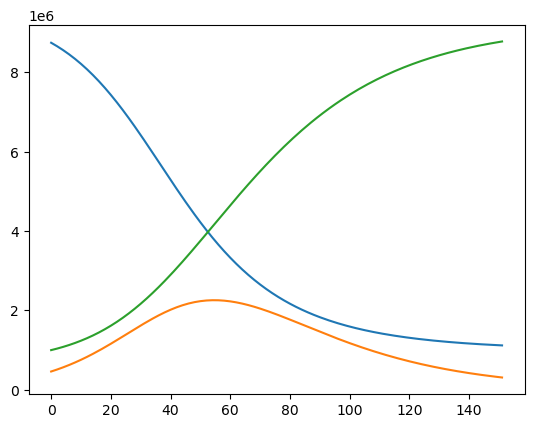

In [5]:
out = solver.bSIRSolve(y0)
print(out[0])
plt.plot(out)


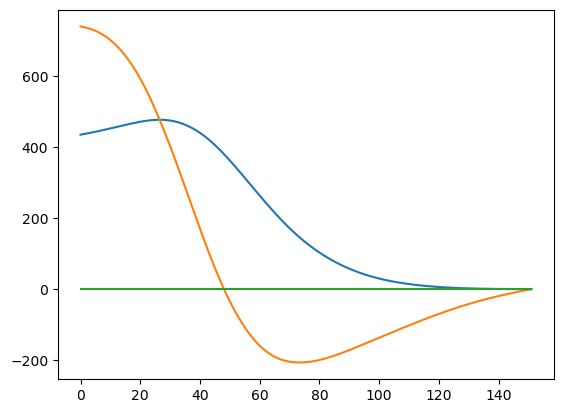

In [6]:
out2 = solver.backwardsSolve2()
plt.plot(out2/1000000)
y0 = out2[0]

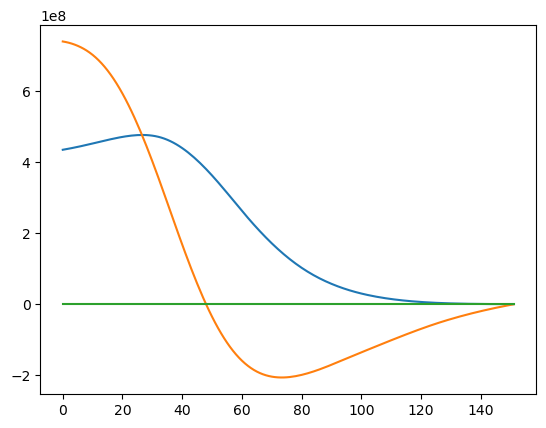

In [7]:
plt.plot(solver.forwardLambdaSolve(y0))

In [8]:

plt.plot(solver.backwardsSolve())
print(out2[0])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
solver = solveSIR(S_true = S, I_true = I, R_true = R, N = 10200000, p_0 = (0, 0, S_0, I_0, R_0))

solver.fit()

round: 1


TypeError: 'interp1d' object is not subscriptable

In [ ]:
import matplotlib.pyplot as plt
plt.plot( np.arange(0, len(values), 1), values[:,0])
plt.plot( np.arange(0, len(values), 1), values[:,1])
plt.plot( np.arange(0, len(values), 1), values[:,2])

NameError: name 'values' is not defined

In [ ]:
def SIR(V, t, *args):

    N, B, g  = args
    S, I, R = V

    dS = -(B/N)*S*I
    dI = (B/N)*S*I - g*I
    dR = g*I

    return dS, dI, dR

def forwardSolve(model, initial_values, params):
    time_steps = np.arange(0, 22, 1)
    from scipy.integrate import odeint
    return odeint(model, t = time_steps, y0 = initial_values, args = params)


In [ ]:
values = forwardSolve(SIR,  )


solver = solveSIR(S_true = S, I_true = I, 
                  R_true = R, N = 10200000, 
                  p_0 = (3, 1, S_0, I_0, R_0))
solver.fit()
plt.plot( np.arange(0, len(values), 1), values[:,0])
plt.plot( np.arange(0, len(values), 1), values[:,1])
plt.plot( np.arange(0, len(values), 1), values[:,2])

TypeError: forwardSolve() missing 2 required positional arguments: 'initial_values' and 'params'

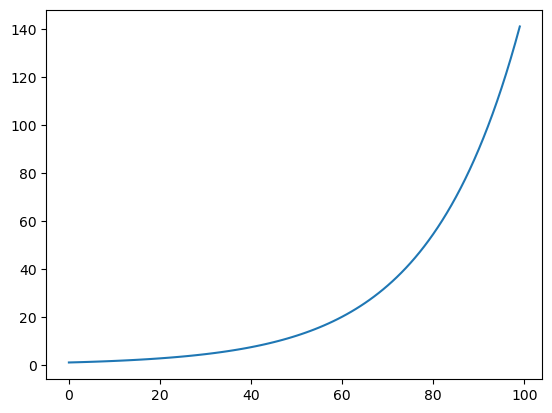

In [ ]:
# Define the ODE: dx/dt = a * x
from scipy.integrate import odeint
def dx(x, t, a):
    return a*x

# Function to solve the ODE given initial condition x_0, parameter a, and time steps
def odesolve(x_0, a, time_steps):
    return odeint(func = dx, y0 = x_0, t=time_steps, args=(a,))

out = odesolve(1.0, 0.5, np.arange(0,10, .1))
import matplotlib.pyplot as plt

plt.plot(np.arange(0,100, 1), out)

In [ ]:
out

array([[1.]])

In [ ]:

# Define the ODE: dx/dt = a * x
from scipy.integrate import odeint
def dx(x, t, a):
    return a*x

# Function to solve the ODE given initial condition x_0, parameter a, and time steps
def odesolve(x_0, a, time_steps):
    return odeint(func = dx, y0 = x_0, t=time_steps, args=(a,))



def checkEquation():
        
        a = 0.5
        x_0 = 1.0
        t = np.linspace(0, 10, 100000000)

        #It should be the case that 
        #x[i+1] - x[i] = dx
        X = odesolve(x_0, a, t)


        dX = a*X
        dt = t[1]-t[0]

        #print(dX[0])

        diffs = np.abs(dX[:-1,] - (X[1:,] - X[0:-1,])/dt)
        return np.mean(diffs)

checkEquation()


6.529849434139754e-07

In [ ]:
def checkEquation():
    a = 0.5
    x_0 = 1.0
    t = np.linspace(0, 10, 1000)
    dt = t[1] - t[0]

    X = odesolve(x_0, a, t)
    dX = a * X

    numerical_derivative = (X[1:,] - X[:-1,]) / dt
    analytical_derivative = dX[:-1,]

    relative_error = np.abs((numerical_derivative - analytical_derivative)/analytical_derivative)
    max_error = np.max(relative_error)
    mean_error = np.mean(relative_error)

    print(f"Maximum relative error: {max_error}")
    print(f"Mean relative error: {mean_error}")

    return max_error, mean_error

max_error, mean_error = checkEquation()


NameError: name 'odesolve' is not defined

In [ ]:
checkEquation()

[[0.00075263]
 [0.00075641]
 [0.0007602 ]
 [0.00076627]
 [0.00077116]
 [0.00077411]
 [0.00077663]
 [0.00078045]
 [0.00078438]
 [0.00078837]
 [0.00079225]
 [0.00079624]
 [0.00080022]
 [0.00080431]
 [0.00080829]
 [0.00081242]
 [0.00081647]
 [0.00082057]
 [0.00082472]
 [0.00082888]
 [0.00083305]
 [0.00083722]
 [0.00084147]
 [0.00084574]
 [0.00085001]
 [0.00085428]
 [0.00085852]
 [0.00086275]
 [0.00086705]
 [0.0008714 ]
 [0.00087576]
 [0.00088015]
 [0.00088458]
 [0.00088902]
 [0.00089349]
 [0.00089796]
 [0.00090246]
 [0.00090699]
 [0.00091154]
 [0.00091615]
 [0.00092071]
 [0.00092533]
 [0.00092997]
 [0.00093464]
 [0.00093933]
 [0.00094405]
 [0.00094878]
 [0.00095351]
 [0.00095825]
 [0.00096303]
 [0.00096783]
 [0.00097266]
 [0.00097752]
 [0.00098241]
 [0.00098734]
 [0.0009923 ]
 [0.0009973 ]
 [0.00100234]
 [0.00100742]
 [0.00101253]
 [0.00101767]
 [0.0010228 ]
 [0.00102796]
 [0.00103314]
 [0.00103835]
 [0.00104358]
 [0.00104884]
 [0.00105411]
 [0.00105941]
 [0.00106472]
 [0.00107005]
 [0.00

22.142447980590916